We were given a dataset which was originally collected and distributed by the“National Institute of Diabetes and Digestive and Kidney Diseases”. The task for us was predicting whether a patient has diabetes or not, based on the diagnostic measurements gathered. All patients are women 21 years and above, belonging to the Pima Indian heritage.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


My 'outcome' column is binary, this is therefore a classification problem.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We have 768 rows and 9 columns. Out of the 9 columns, none are categorical. There are no missing values; however, some of the columns have nulls in them.

In [ ]:
#I will see if there are zeroes in the data; then replace them with mean values
df['Glucose']=df['Glucose'].replace(0,df['Glucose'].mean())
df['BloodPressure']=df['BloodPressure'].replace(0,df['BloodPressure'].mean())
df['SkinThickness']=df['SkinThickness'].replace(0,df['SkinThickness'].mean())
df['Insulin']=df['Insulin'].replace(0,df['Insulin'].mean())
df['BMI']=df['BMI'].replace(0,df['BMI'].mean())

The categories: DiabetesPedigreeFunction and Age do not have any null values. I will leave them as they are.

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.127964       0.208984       0.013376   
Glucose                      0.127964  1.000000       0.219666       0.160766   
BloodPressure                0.208984  0.219666       1.000000       0.134155   
SkinThickness                0.013376  0.160766       0.134155       1.000000   
Insulin                     -0.018082  0.396597       0.010926       0.240361   
BMI                          0.021546  0.231478       0.281231       0.535703   
DiabetesPedigreeFunction    -0.033523  0.137106       0.000371       0.154961   
Age                          0.544341  0.266600       0.326740       0.026423   
Outcome                      0.221898  0.492908       0.162986       0.175026   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.018082  0.021546                 -0.033523   
Glucose                   0.396597  0.231

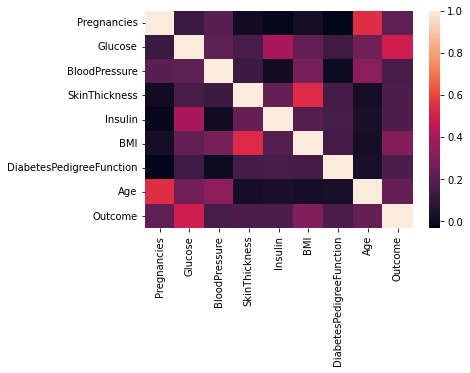

In [ ]:
#I will now find the correlation between features and visualise it using seaborn.
correlation = df.corr()
print(correlation)
sns.heatmap(correlation,
            xticklabels=correlation.columns,
            yticklabels=correlation.columns)


I can see Glucose and BMI have the biggest correlation with Outcome. These features will probably have the biggest impact on the model.

In [ ]:
# I will split the feature and target variables into training and test sets. 
# I will go for a 80-20 split.
X=df.drop('Outcome',axis=1)
y=df['Outcome']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0)

In [ ]:
# Before running the random forest classifier, I will scale the feature variables using StandardScaler
from sklearn.preprocessing import StandardScaler
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)

In [ ]:
# I will first run the model using the standard parameters, and then I will attempt to tune them.
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
rfc = RandomForestClassifier(random_state=30)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(metrics.roc_auc_score(y_test, predictions))
print(metrics.precision_score(y_test,predictions))


0.8246753246753247
0.7962815669119109
0.7083333333333334


My accuracy with the standard parameters is 0.82, and the AUC is 0.79, which is already quite good. The precision score could be improved (only 0.7). I will try to finetune the parameters to achieve an even better outcome.

In [ ]:
#Hyperparameter tuning

rfc = RandomForestClassifier(random_state=30)

print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 30, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)




{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=30, n_jobs=-1)
# Fit the random search model
rf_random.fit(X_train, y_train)



In [ ]:
# These are the best parameters:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [ ]:
# I will now fit a new model with these parameters, and see if it yields better results

rf_new = RandomForestClassifier(n_estimators= 1800,
                              min_samples_split= 2,
                              min_samples_leaf= 1,
                              max_features= 'auto',
                              max_depth= 50,
                              bootstrap= True)
rf_new.fit(X_train, y_train)
rf_new.predict(X_test)
rf_new.score(X_test, y_test)


0.8246753246753247

In [ ]:
#I will now finetune the hyperparameters with Gridsearch

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1600, 1800, 2000, 2200]
}
# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

grid_search.best_params_


In [ ]:
# I will now feed the best parameters that I got from Grid Search into my new model.
rf_new = RandomForestClassifier(n_estimators=1900,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features='auto',
                                max_depth=60,
                                bootstrap=True)
rf_new.fit(X_train, y_train)
predictions = rf_new.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(metrics.roc_auc_score(y_test, predictions))
print(metrics.precision_score(y_test, predictions))


0.8311688311688312
0.8009544641081726
0.723404255319149


I got an accuracy of 0.831 and AUC of 0.8 with the hyperparameters tuned. The precision improved by 2%. I will stop here and consider this the best model, as the improvement is minimal. (1-2%)

## I will now proceed with AutoML.

In [ ]:
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [ ]:
# I will first set up data using the setup() function

In [ ]:
import pycaret
from pycaret.classification import *
s = setup(data, target = 'Outcome', session_id=76,numeric_features=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'], normalize=True,log_experiment = True, train_size=0.8,bin_numeric_features = ['Age'],experiment_name = 'diabetes')

,Description,Value
0,session_id,76
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:Logging experiment in MLFlow
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['Pregnancies',
                                                          'Glucose',
                                                          'BloodPressure',
                                                          'SkinThickness',
                                                          'Insulin', 'BMI',
                                                          'DiabetesPedigreeFunction',
                                                          

In [ ]:
# Now I will pretrain all the models 
compare_models(sort='AUC', turbo = False)

The 3 top models without tuning hyperparameters are:

Random Forest -> AUC 0.8361 Accuracy 0.7691

Logistic Regression -> AUC 0.8350 Accuracy 0.7766

Catboost -> AUC 0.8338 Accuracy 0.7618

I will now further try to improve these models.

In [ ]:
#First, I will create a random forest classifier and tune it using the hyperparameters I obtained when I ran Grid Search.
random_forest = create_model('rf')
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1600, 1800, 2000, 2200]
}
tuned_random_forest = tune_model(random_forest, n_iter = 50, custom_grid = param_grid, optimize = 'AUC')


In [ ]:
predict_model(tuned_random_forest)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=2200,
                       n_jobs=-1, oob_score=False, random_state=5863, verbose=0,
                       warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7965,0.8569,0.6479,0.6765,0.6619,0.5165,0.5167


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age_0.0,Age_1.0,Age_10.0,Age_2.0,...,Pregnancies_3.0,Pregnancies_4.0,Pregnancies_5.0,Pregnancies_6.0,Pregnancies_7.0,Pregnancies_8.0,Pregnancies_9.0,Outcome,Label,Score
0,0.000511,1.172778,-0.664194,-0.404044,0.319168,-0.541465,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5458
1,-1.683046,0.497804,2.388662,-0.778589,0.099683,-0.148300,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8809
2,1.684069,-0.177171,-1.341466,0.545253,-0.412451,-0.329990,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5773
3,-1.055838,-0.852146,-0.927008,-0.627908,-1.085540,2.371536,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9148
4,-0.296587,0.329060,-0.664194,-0.404044,0.114315,-0.577208,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,-0.527664,-1.358377,0.005524,0.512964,-0.514877,-0.136386,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8322
227,-0.428631,-0.852146,1.456130,0.125498,0.480124,0.125725,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7215
228,-0.659707,0.160316,-0.664194,-0.404044,-0.441715,-1.044837,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7452
229,1.915145,0.497804,3.735652,-1.112240,3.933366,5.802801,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5806


The accuracy and AUC have improved over the untuned model. They are now, respectively, 0.7965 and 0.8569

In [ ]:
#I will now conduct the same procedure for Logistic Regression
log_reg = create_model('lr')
params_lr = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'penalty': ['none', 'l1', 'l2', 'elasticnet'],
     'C': [100,10,1.0,0.1,0.01]        
    
}
tuned_log_reg = tune_model(log_reg, n_iter = 50, custom_grid = params_lr,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7258,0.8091,0.4545,0.6667,0.5405,0.3550,0.3682
1,0.7903,0.8784,0.6818,0.7143,0.6977,0.5373,0.5377
2,0.8065,0.8625,0.5909,0.8125,0.6842,0.5496,0.5641
3,0.7903,0.8875,0.5909,0.7647,0.6667,0.5174,0.5265
4,0.7541,0.8119,0.4286,0.7500,0.5455,0.3936,0.4226
5,0.7541,0.8488,0.6190,0.6500,0.6341,0.4491,0.4494
6,0.8361,0.9060,0.7143,0.7895,0.7500,0.6285,0.6302
7,0.6721,0.7738,0.4286,0.5294,0.4737,0.2394,0.2422
8,0.7705,0.8167,0.5238,0.7333,0.6111,0.4547,0.4676


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=76, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
predict_model(tuned_log_reg)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=76, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8247,0.8649,0.6038,0.8421,0.7033,0.5836,0.5999


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age_0.0,Age_1.0,Age_10.0,...,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,Outcome,Label,Score
0,0.646755,0.095935,-0.371461,0.337070,0.025125,-0.367272,-0.053507,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5357
1,1.239895,-0.064636,1.129128,-0.645217,-0.410518,-0.596439,-0.649198,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8803
2,-0.836096,-1.156517,-0.538193,2.620601,-0.570897,1.251220,1.262826,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8008
3,-0.539526,-0.546348,0.212102,-0.645217,-0.410518,-1.326910,0.225451,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.7751
4,-0.242956,-1.541886,-0.371461,0.129476,-0.787632,-0.410241,-0.550400,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1.833035,1.252044,-0.371461,-0.389509,0.155166,-1.011805,-0.454509,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.7333
150,-0.539526,-0.450005,-0.704925,-0.645217,-0.410518,-0.252689,-0.942685,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9007
151,-0.539526,-0.546348,-1.205121,1.375039,-0.256631,0.334552,-0.747996,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8711
152,-1.132666,1.380501,1.462592,0.648460,6.093707,2.826744,-0.161022,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.7319


The improvement here is much more significant. We are getting accuracy 0.82 and AUC 0.86. The precision score also improved, from 0.7 to 0.84

In [ ]:
evaluate_model(tuned_log_reg)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=76, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
# Lastly, I will run the catboost classifier.
cat = create_model('catboost')
params_cat = {
    'max_depth' : [5,6,7,8,9],
     'n_estimators': [1800, 2000, 2200,2400],
     'loss_function':['LogLoss','CrossEntropy']        
    
}
tuned_cat = tune_model(cat, n_iter = 50,custom_grid = params_cat, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7037,0.7632,0.5500,0.6111,0.5789,0.3514,0.3525
1,0.8148,0.8441,0.7000,0.7778,0.7368,0.5946,0.5966
2,0.7407,0.7926,0.7000,0.6364,0.6667,0.4553,0.4567
3,0.7407,0.7956,0.5000,0.7143,0.5882,0.4075,0.4213
4,0.7963,0.8221,0.7000,0.7368,0.7179,0.5587,0.5591
5,0.7222,0.7824,0.8000,0.5926,0.6809,0.4444,0.4602
6,0.7407,0.7618,0.6000,0.6667,0.6316,0.4324,0.4339
7,0.7925,0.8111,0.6842,0.7222,0.7027,0.5435,0.5439
8,0.8113,0.8483,0.5263,0.9091,0.6667,0.5478,0.5876


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 27
INFO:logs:<catboost.core.CatBoostClassifier object at 0x7fe867f4c550>
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
predict_model(tuned_cat)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostClassifier object at 0x7fe867f4c550>, probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7532,0.8312,0.6056,0.5972,0.6014,0.4227,0.4227


,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age_0.0,Age_1.0,Age_10.0,Age_2.0,...,Pregnancies_3.0,Pregnancies_4.0,Pregnancies_5.0,Pregnancies_6.0,Pregnancies_7.0,Pregnancies_8.0,Pregnancies_9.0,Outcome,Label,Score
0,0.000511,1.172778,-0.664194,-0.404044,0.319168,-0.541465,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5039
1,-1.683046,0.497804,2.388662,-0.778589,0.099683,-0.148300,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9977
2,1.684069,-0.177171,-1.341466,0.545253,-0.412451,-0.329990,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7913
3,-1.055838,-0.852146,-0.927008,-0.627908,-1.085540,2.371536,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9999
4,-0.296587,0.329060,-0.664194,-0.404044,0.114315,-0.577208,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,-0.527664,-1.358377,0.005524,0.512964,-0.514877,-0.136386,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9977
227,-0.428631,-0.852146,1.456130,0.125498,0.480124,0.125725,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9311
228,-0.659707,0.160316,-0.664194,-0.404044,-0.441715,-1.044837,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9807
229,1.915145,0.497804,3.735652,-1.112240,3.933366,5.802801,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9495


The catboost classifier seems to be the weakest of the three.
I will now run blender and stacker to see whether combining the models will yield better results.

In [ ]:
blender = blend_models([tuned_random_forest,tuned_log_reg,tuned_cat])
stacker = stack_models([tuned_random_forest,tuned_log_reg,tuned_cat])
best_auc_model = automl(optimize = 'AUC')

In [ ]:
pred_1 = predict_model(best_auc_model)
pred_3 = predict_model(stacker)
pred_4 = predict_model(blender)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=5863, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8225,0.8606,0.6338,0.75,0.687,0.5644,0.5683


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=80,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=3,
                                             

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8009,0.862,0.6056,0.7049,0.6515,0.5132,0.5161


INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=80,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=3,
                    

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7835,0.8533,0.6056,0.6615,0.6324,0.4794,0.4803


My best classifier is Logistic Regression. Here's the full accuracy scores:

Model	Accuracy	AUC	Recall	Prec.	F1	Kappa	MCC

Logistic Regression	0.8247	0.8649	0.6038	0.8421	0.7033	0.5836	0.5999

# Discussion section

# AutoML and Pycaret
AutoML is an automated machine learning method which aims to provide methods and processes that streamline and automate mundane tasks which are carried out repeatedly by data scientists, such as preprocessing, data preparation, model creation, hyperparameter tuning, feature selection, automatic analysis etc. This makes it possible for people with little to no Data Science knowledge to carry out experiments and apply Machine Learning solutions to real-world problems. Automating the machine learning pipeline can also provide faster and more accurate results than hard-coded algorithms. AutoML is an exciting milestone in AI, as it helps to make machine learning more accessible and easier to understand for laypeople. The algorithm “learns about learning”, as with every iteration of the model, the data is fed back through the same pipeline. The algorithm also takes care of the parts of the machine learning pipeline which apply the algorithm to real-world scenarios, saving time and resources for the data scientist. All in all, AutoML represents a step towards general AI, the goal of creating an AI so complex it will be able to emulate the human mind and understand, learn and perform tasks much like a human being.

Pycaret is an open-source, low-code Python machine learning library which allows the user to run data science experiments and algorithms with just a few lines of code. It provides an easy to use interface and is straightforward to interact with. It can act as an end-to-end ML tool which will accelerate the data science cycle and increase productivity. As of right now, Pycaret supports Binary/Multi-class Classification, Regression, Clustering, Anomaly Detection, Natural Language Processing (Topic Modelling), and Association Rules Mining. Pycaret recently announced that it introduced a new module for working with time-series data. This module will definitely be interesting to look at in the future, especially when I am working on my Final Year project.

The library imports all data and pre-processes it, giving the user the option to impute data types and set up various parameters. Data preparation encompasses transformations such as missing value imputation, scaling, categorical encoding, feature binning, feature engineering and feature selection.The setup, tuning of model and subsequent predictions can all be achieved in a few lines of code. Using the compare_models function, the data scientist can then see pre-trained models which are best suited for the type of dataset and choose the most optimal one. The model will be trained on all default parameters, which can then be customised. All of the steps performed can be reproduced using a pipeline and deployed for production. The simplicity of use allows its users to focus on more pressing matters, like properly preparing data and finding the optimal parameters to achieve a higher accuracy.


Pycaret’s tune_model function makes it incredibly easy to tune hyperparameters to achieve a higher accuracy. While it might be tempting to use the default tune_model parameters and not pass a special grid to our model, this could in some cases be a hindrance. While tuning the model it is important to do research and explore different methods of finding the best hyperparameters, as those set default by Pycaret can impact the accuracy negatively. This is in fact what happened to me - after creating models in Pycaret, I attempted to tune them without passing custom grids to the tune_model function, simply using the default metrics. My accuracy metrics suffered greatly. After this I resorted to performing grid search and random search and passing specific grids to the tune_model function, which in the end greatly improved the accuracy of the predictions.

After training, the evaluate_model function allows us to see the accuracy scores and plots various metrics, such as feature importance, confusion matrices, AUC, decision trees, thresholds, learning curves, decision boundaries and more.
Pycaret also allows data scientists to blend, stack and ensemble models. In my case, these models achieved a lower (or roughly the same) accuracy than my highest-performing model, but with enough research and careful model blending this could definitely yield interesting results.


# Random Forest v Pycaret - Comparison and Discussion

Pycaret’s compare_models( ) function returned a list of pre-trained models that already had high AUC scores (this is the metric I sorted by). I picked 3 of the highest-scoring models (they all had around 0.82 AUC) and tried to make them even more accurate by tuning the hyperparameters. Those models were Random Forest, Logistic Regression and Catboost.

When searching for hyperparameters for (my hard-coded) Random Forest, I performed grid search as well as randomised search. After getting the base parameters from randomised search, I added boundary values and performed grid search to figure out the best combination of hyperparameters. Despite the algorithm taking a long time to run, I achieved an improvement in the accuracy - although minimal, which led me to believe the model wouldn’t improve much further. My final scores for Random Forest were 0.83 for Accuracy and 0.8 for AUC. 

The improvement for Pycaret’s Logistic Regression in terms of parameter tuning was very noticeable - Accuracy rose from 0.76 to 0.82 and AUC from 0.83 to 0.86. My Precision score also improved by a lot, from 0.7 to 0.84. I am assuming this is because I tried hyperparameter tuning for a wide grid, over many iterations.

For the rest of my Pycaret models, there was also improvement in accuracy after tuning, but the improvements were minimal and they did not come close to the scores achieved with Logistic Regression.


# Below some plots for my best model (Logistic Regression)

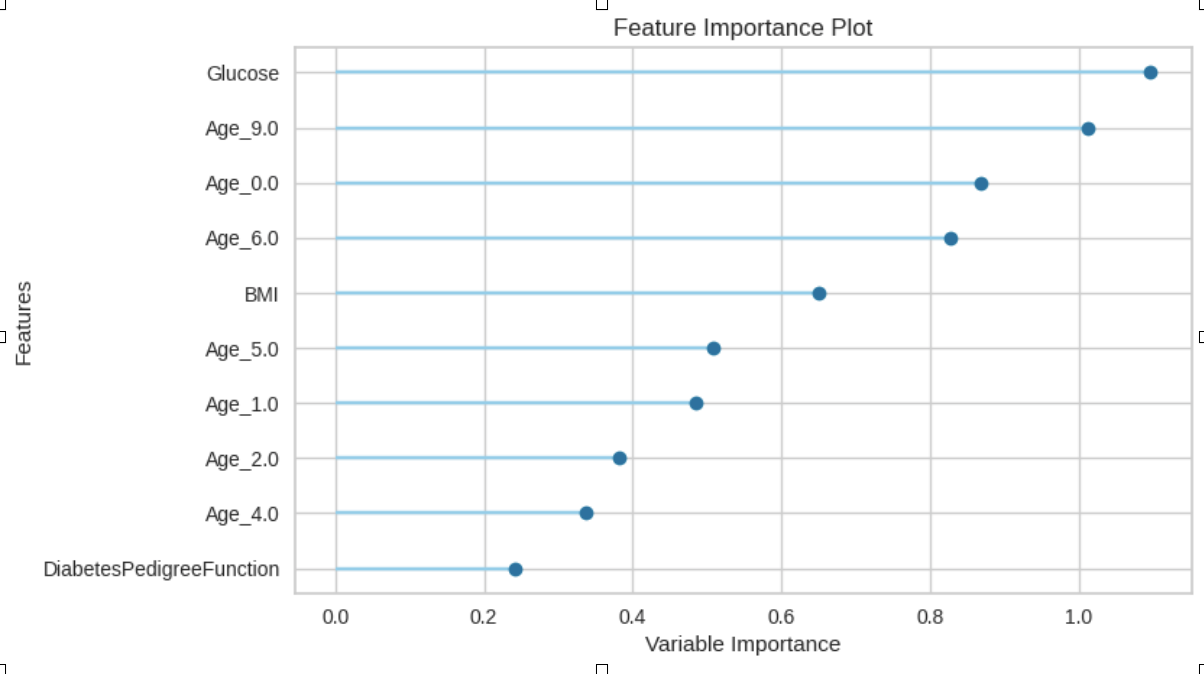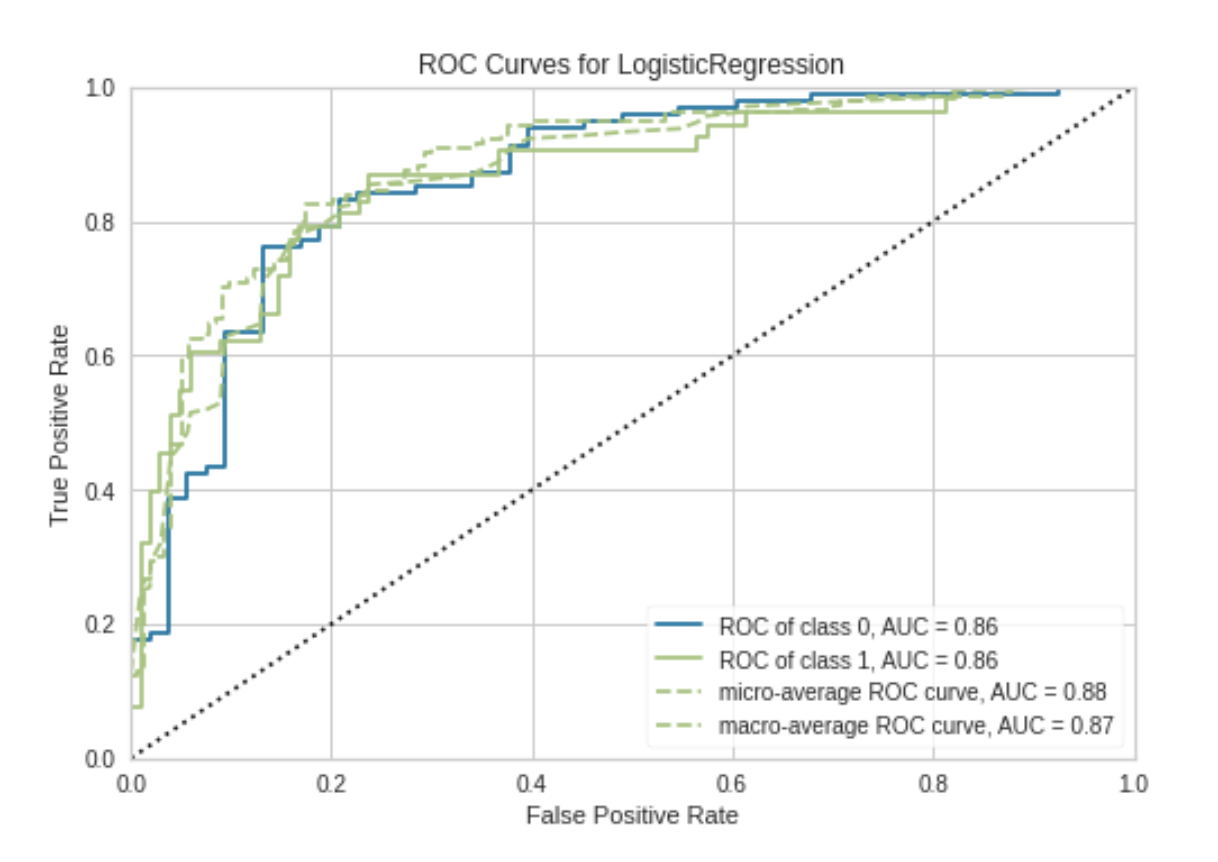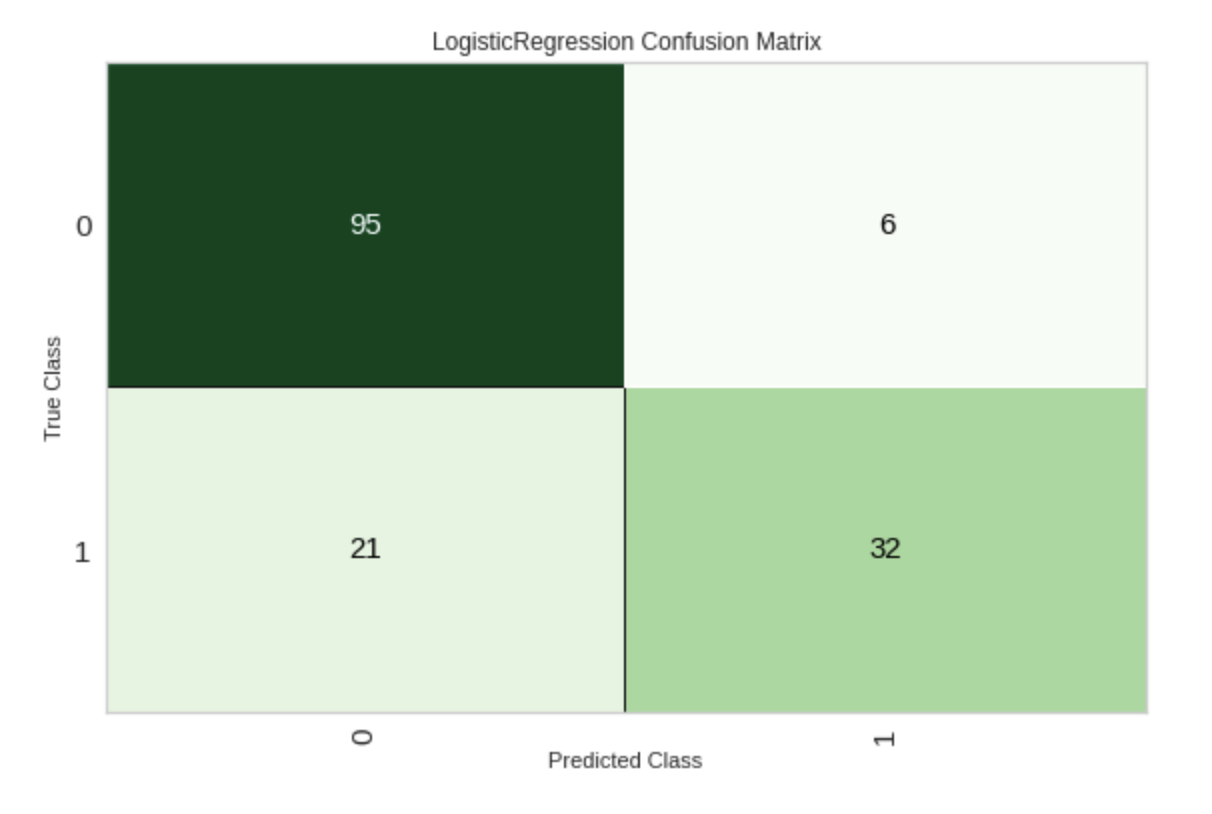

Overall, my Logistic Regression model outperforms the hard-coded Random Forest Classifier.
My assumption is that this is the case because I introduced feature binning in Logistic Regression. This can be observed on the plot above. The numerical feature of Age was One-Hot encoded as if it was a categorical feature, which should’ve given the specific values more weight. Overall, the Glucose levels were still the most important feature, which was to be expected. From the correlation plot created while running Random Forest experiments, I deduced Glucose and BMI will have the biggest consequence on the model. I was partially correct, as seen on the plot above, but the age of the person clearly also plays a big role in diabetes prediction.



# Future Suggestions

My precision and recall scores could still be improved. As the ratio of non-diabetics to diabetics in the dataset is almost 2:1, the data is very inbalanced. As such, the models are classifying non-diabetics correctly, but there is a high percentage of diabetics that are still being misclassified as non-diabetics (large amount of False Negatives). If the dataset was more balanced, perhaps we could achieve a higher accuracy. As a future suggestion, I would aim to make a dataset with a 50/50 split of non- and diabetics, or perhaps even increase the number of diabetics to non-diabetics, as then the model could more accurately learn the features which are more prominent in diabetics. This dataset is also relatively small (only around 800 rows). Increasing the size of the dataset would undoubtedly introduce variability in the data and potentially improve predictions.
To combat the unbalanced nature of the data, it might be useful to look into upsampling the diabetics - for example using SMOTE to create more data points which would have diabetes outcome = 1. It would be interesting to see if using that approach might have a bigger impact on the accuracy of predictions.
